# Overconfident predictions

Sometimes neural networks are overconfident: they offer a wrong prediction with high confidence.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

We first train a simple fully connected neural network with one hidden layer with the MNIST data set. 

In [2]:
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0  # normalise as weight initialisation expects inputs in [0,1]

In [3]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',  # we could have chosen SGD as well, but Adam seems faster
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2589 - accuracy: 0.9262
Epoch 2/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1154 - accuracy: 0.9662
Epoch 3/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0782 - accuracy: 0.9764
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0583 - accuracy: 0.9823
Epoch 5/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0455 - accuracy: 0.9861


In [4]:
model.evaluate(X_test,  y_test, verbose=2)

313/313 - 0s - loss: 0.0753 - accuracy: 0.9772 - 372ms/epoch - 1ms/step


[0.07525556534528732, 0.9771999716758728]

As we can see, accuracy on the test set is with 97% very good. Let's also look at the predictions and confidence levels for a number of samples:

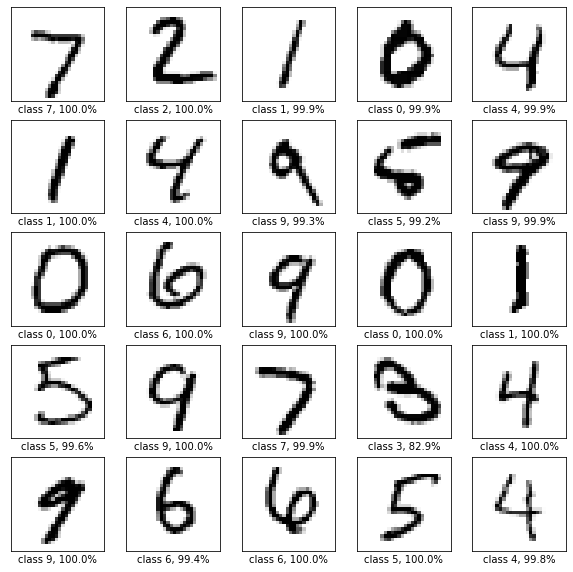

In [7]:
def show_results(clf,X):
    predictions=clf.predict(X)
    N=len(X)
    nrows=math.ceil(N/5)
    _,axs=plt.subplots(nrows,5,figsize=(10,nrows*2))
    axs=axs.flat
    for i,ax in enumerate(axs):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(X[i], cmap='binary')
        ax.set_xlabel("class {}, {:2.1f}%".format(np.argmax(predictions[i]),np.max(predictions[i])*100))
    plt.show()
show_results(model,X_test[:25])

Seems fine. 

## Now, let's fool the network

We do that by passing datapoints into the network that are quite unlike the data that the network saw during training ("out of distribution" data). First, we simply input noise:

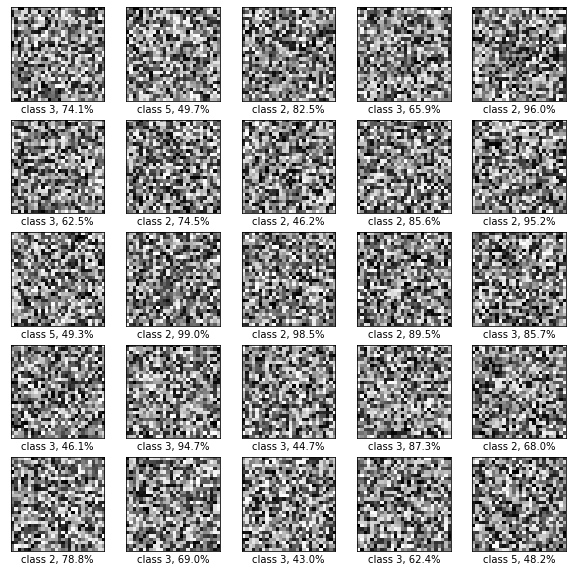

In [8]:
noises=np.array([np.random.rand(28,28) for i  in range(25)])
show_results(model,noises)

Note the high confidence levels! Curiously, most are predicted to show a '3'.

Next, we input samples from the fashion data set. 

In [9]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(fashion_train, fashion_train_labels), (fashion_test, fashion_test_labels) = fashion_mnist.load_data()
fashion_train, fashion_test = fashion_train / 255.0, fashion_test / 255.0

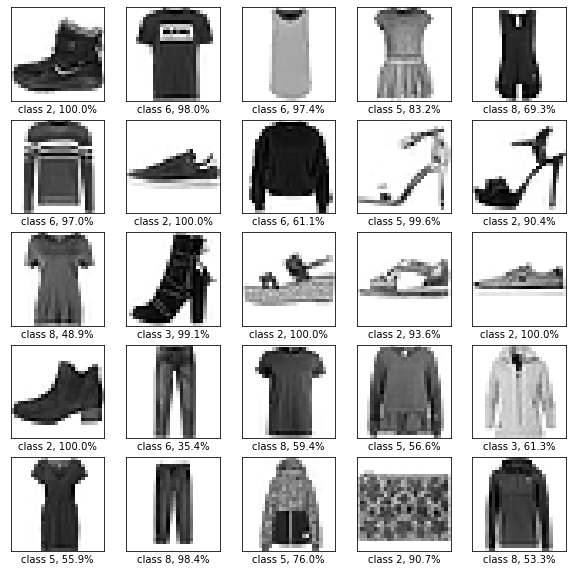

In [10]:
show_results(model,fashion_train[:25])

Clearly, that first shoe is a '2'! Again note the high confidence levels. Intuitively, I think most of us would expect much lower confidence levels, namely around 10% (as the network was trained on 10 classes), since a shoe should be equally far from each of the digits '0' to '9'. An output of around 10% for each of the classes would signal that the network is unsure which digit the shoe is -- this, however, is not happening. The shoe is a '2' and the network 100% sure. 